Vehicle spawned at Location(x=109.946968, y=-17.187952, z=0.599999)
Vehicle navigating with noisy waypoints...
Noisy Waypoint Applied: Location(x=109.724648, y=-21.970570, z=0.000000)
Noisy Waypoint Applied: Location(x=110.033714, y=-27.456549, z=0.000000)
Noisy Waypoint Applied: Location(x=108.682106, y=-33.022030, z=0.000000)
Noisy Waypoint Applied: Location(x=107.201050, y=-38.850937, z=0.000000)
Noisy Waypoint Applied: Location(x=105.054901, y=-43.871483, z=0.000000)
Noisy Waypoint Applied: Location(x=101.656067, y=-48.988224, z=0.000000)
Noisy Waypoint Applied: Location(x=98.282913, y=-53.583733, z=0.000000)
Noisy Waypoint Applied: Location(x=93.925049, y=-57.311619, z=0.000000)
Noisy Waypoint Applied: Location(x=89.130386, y=-60.601158, z=0.000000)
Noisy Waypoint Applied: Location(x=84.135323, y=-63.480988, z=0.000000)
Noisy Waypoint Applied: Location(x=79.073074, y=-66.037720, z=0.000000)
Noisy Waypoint Applied: Location(x=73.571335, y=-66.894035, z=0.000000)
Noisy Waypoint Appl

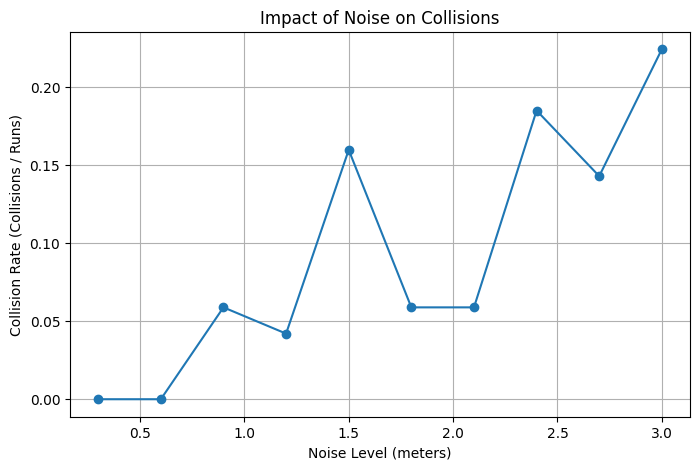

In [1]:
import carla
import time
import datetime
import random
import pandas as pd
import matplotlib.pyplot as plt

# Connect to CARLA
client = carla.Client('localhost', 2000)
client.set_timeout(5.0)
world = client.get_world()

# Get map and spawn points
map = world.get_map()
spawn_points = map.get_spawn_points()
start_point = random.choice(spawn_points)

# Spawn the vehicle
vehicle_bp = world.get_blueprint_library().filter('*firetruck*')[0]
vehicle = world.try_spawn_actor(vehicle_bp, start_point)

if not vehicle:
    print("Failed to spawn vehicle.")
    exit()

print(f"Vehicle spawned at {start_point.location}")

# Disable autopilot (We will manually apply noisy waypoints)
vehicle.set_autopilot(False)

# Attach Collision Sensor
collision_bp = world.get_blueprint_library().find('sensor.other.collision')
collision_sensor = world.spawn_actor(collision_bp, carla.Transform(), attach_to=vehicle)

# Set up CSV File for Results
csv_filename = "waypoint_noise_incidents_10.csv"
data_records = []
run_counts = {}  # Track runs per noise level

# Initial Noise Level
noise_level = 0.3  # Start small (0.3m)
noise_increment = 0.3  # Increase every minute
experiment_duration = 10 * 60  # 10 minutes in seconds
noise_update_interval = 60  # Increase noise every 60 seconds

# Track simulation time
start_time = time.time()
crash_count = 0  # Track number of crashes

# Collision detection function

def collision_callback(event):
    global crash_count
    print("Collision detected!")
    crash_count += 1
    
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    data_records.append({
        "Timestamp": timestamp,
        "Noise_Level": noise_level,
        "Collision": "Yes",
        "Waypoint_X": None,
        "Waypoint_Y": None,
        "Waypoint_Z": None,
        "Noisy_Waypoint_X": None,
        "Noisy_Waypoint_Y": None,
        "Noisy_Waypoint_Z": None
    })
    
    # Reset vehicle to a new random spawn point
    reset_location = random.choice(spawn_points)
    vehicle.set_transform(reset_location)
    print("Vehicle reset after collision. Continuing experiment.")

# Cleanup function
def cleanup():
    print("Cleaning up...")
    df = pd.DataFrame(data_records)
    df.to_csv(csv_filename, index=False)
    print(f"Incident data saved to {csv_filename}")
    print(f"Total crashes recorded: {crash_count}")

    if collision_sensor:
        collision_sensor.destroy()
    if vehicle:
        vehicle.destroy()
    print("Vehicle & sensors destroyed. Exiting program.")

    # Generate Graph
    plot_results(df)

# Noisy Waypoint Function
def noisy_waypoint(original_waypoint, noise):
    noisy_x = original_waypoint.transform.location.x + random.uniform(-noise, noise)
    noisy_y = original_waypoint.transform.location.y + random.uniform(-noise, noise)
    return carla.Transform(carla.Location(x=noisy_x, y=noisy_y, z=original_waypoint.transform.location.z), original_waypoint.transform.rotation)

# Visualization Function
def plot_results(df):
    plt.figure(figsize=(8, 5))
    df_crash = df[df["Collision"] == "Yes"]
    df_runs = pd.DataFrame(list(run_counts.items()), columns=["Noise_Level", "Runs"])
    df_collisions = df_crash.groupby("Noise_Level").size().reset_index(name="Collisions")
    merged_df = df_runs.merge(df_collisions, on="Noise_Level", how="left").fillna(0)
    merged_df["Collision Rate"] = merged_df["Collisions"] / merged_df["Runs"]
    
    plt.plot(merged_df["Noise_Level"], merged_df["Collision Rate"], marker='o', linestyle='-')
    plt.xlabel("Noise Level (meters)")
    plt.ylabel("Collision Rate (Collisions / Runs)")
    plt.title("Impact of Noise on Collisions")
    plt.grid()
    plt.savefig("collision_rate_plot.png")
    plt.show()

# Start collision sensor
collision_sensor.listen(collision_callback)

print("Vehicle navigating with noisy waypoints...")

try:
    last_noise_update = start_time
    
    while time.time() - start_time < experiment_duration:
        current_time = time.time()
        
        # Increase noise level every minute
        if current_time - last_noise_update >= noise_update_interval:
            noise_level += noise_increment
            last_noise_update = current_time
            print(f"Noise level increased to {noise_level} meters")
        
        if noise_level not in run_counts:
            run_counts[noise_level] = 0
        run_counts[noise_level] += 1
        
        current_location = vehicle.get_location()
        next_waypoint_options = map.get_waypoint(current_location).next(5.0)

        if not next_waypoint_options:
            print("No further waypoints found! Resetting vehicle...")
            vehicle.set_transform(random.choice(spawn_points))
            continue
        
        next_waypoint = next_waypoint_options[0]
        noisy_transform = noisy_waypoint(next_waypoint, noise_level)
        vehicle.set_transform(noisy_transform)

        timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        data_records.append({
            "Timestamp": timestamp,
            "Noise_Level": noise_level,
            "Collision": "No",
            "Waypoint_X": next_waypoint.transform.location.x,
            "Waypoint_Y": next_waypoint.transform.location.y,
            "Waypoint_Z": next_waypoint.transform.location.z,
            "Noisy_Waypoint_X": noisy_transform.location.x,
            "Noisy_Waypoint_Y": noisy_transform.location.y,
            "Noisy_Waypoint_Z": noisy_transform.location.z
        })

        print(f"Noisy Waypoint Applied: {noisy_transform.location}")
        time.sleep(0.5)

except KeyboardInterrupt:
    print("\nManual stop detected! Cleaning up before exiting...")
    cleanup()

cleanup()
